# **Non-Linear Dimensionality Reduction:** 
## A Tutorial on t-SNE and Its Comparison with PCA  Using the Fashion-MNIST Dataset


**Module:** Machine Learning  
**University of Hertfordshire**

---

This notebook explores two dimensionality reduction methods—**Principal Component Analysis (PCA)** and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**—applied to the Fashion-MNIST dataset.  

The purpose is not only to run these algorithms but to **understand why they behave differently** and how they reveal hidden structure in high-dimensional data.


## 1. **Introduction**

High-dimensional datasets are difficult for humans to interpret.  
Techniques like PCA and t-SNE allow us to project data into two dimensions so that we can understand how samples naturally group together.

### Why dimensionality reduction matters
- Helps visualise complex datasets  
- Reveals hidden clusters or patterns  
- Reduces noise  
- Speeds up downstream ML algorithms  

### Real-world analogy  
Imagine arranging thousands of clothing items in a store.  
Each item has many attributes:
- colour  
- material  
- texture  
- shape  
- size  

Humans cannot easily sort items using all these dimensions simultaneously.  
Dimensionality reduction algorithms act like a **store employee who organises clothing into understandable sections**—everything similar appears closer together.

t-SNE excels at forming these "sections", especially in datasets like Fashion-MNIST that contain natural visual clusters.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.datasets import fashion_mnist

plt.style.use("seaborn-v0_8")


## **2. Loading the Fashion-MNIST Dataset**

Fashion-MNIST contains images of clothing items belonging to 10 different categories.  
Each image is:

- grayscale  
- size 28×28  
- represented as 784-dimensional vectors when flattened  

We will downsample to **3,000 images** to keep t-SNE computationally manageable.


In [2]:
# Load Fashion MNIST
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Select first 3000 samples
N = 3000
X = X_train[:N]
y = y_train[:N]

X.shape, y.shape


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 29s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


((3000, 28, 28), (3000,))

## **3. Preprocessing: Flattening and Scaling**

Each 28×28 image is flattened into a 784-dimensional vector.  
Scaling is essential because PCA and t-SNE rely on distances that are sensitive to magnitude.


In [3]:
X_flat = X.reshape(N, -1)   # convert 28x28 into 784 features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

X_flat.shape, X_scaled.shape


((3000, 784), (3000, 784))

## **4. Principal Component Analysis (PCA)**


PCA is a **linear** dimensionality reduction technique.  
It seeks directions (principal components) that capture the maximum variance.

Mathematically: Given covariance matrix for zero-mean data,
$$
C = \frac{1}{n}\, X^{\top} X
$$

PCA finds eigenvectors of \(C\).  
These eigenvectors define new axes that represent maximum variance directions.

**Limitations:**
- PCA can only capture **linear** separations.
- Works well for global structure but not for fine-grained cluster separation.

We start by projecting Fashion-MNIST into **2D** using **PCA**.



In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_pca[:5]


array([[ -0.801794  ,  20.71447601],
       [ 17.07195459,  -4.61679778],
       [ -9.43838686, -12.19847705],
       [ -0.1632684 , -11.42167645],
       [  9.06916254, -12.81845513]])

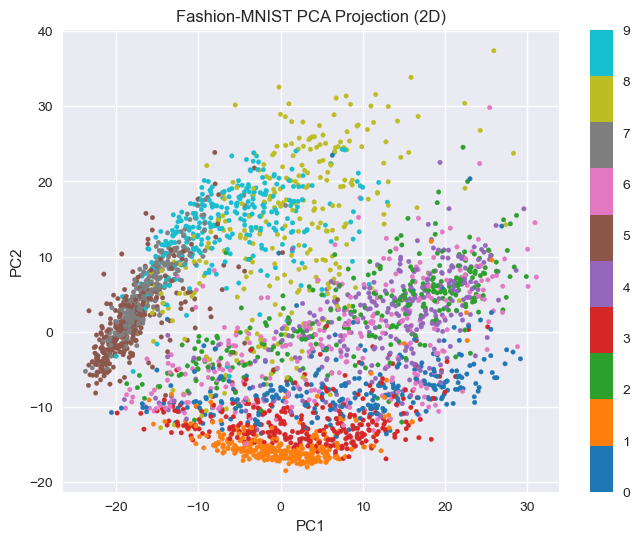

In [5]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=10)
plt.title("Fashion-MNIST PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, ticks=range(10))
plt.show()


### PCA Interpretation

The PCA plot shows some coarse grouping; however:

- Many classes overlap heavily.
- PCA cannot separate curved or complex manifolds.
- Global structure is preserved, but local clusters blend together.

This motivates the need for **non-linear** dimensionality reduction.


## **5. Understanding t-SNE**

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a **non-linear technique** designed for visualising high-dimensional data.

### Core idea
t-SNE converts distances in high-dimensional space into **probabilities**, then tries to recreate similar probabilities in low-dimensional space.

### Step-by-step understanding
1. Compute pairwise similarities  
2. Convert similarities into probabilities  
3. Construct a low-dimensional distribution  
4. Minimise the **Kullback–Leibler (KL) divergence** between the two distributions  

### Why t-SNE works better than PCA for images
Images often lie on **non-linear manifolds**.  
t-SNE preserves **local neighbourhoods**, meaning:
- Points that are similar in pixel space stay close in 2D.
- Different classes form separate, meaningful clusters.

We now apply t-SNE to our 3,000 samples.


In [6]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

X_tsne[:5]


array([[-32.29538   ,  40.06716   ],
       [ 34.530643  , -20.21002   ],
       [  0.90768623, -14.379708  ],
       [  8.928598  , -15.362022  ],
       [  4.906147  , -34.42631   ]], dtype=float32)

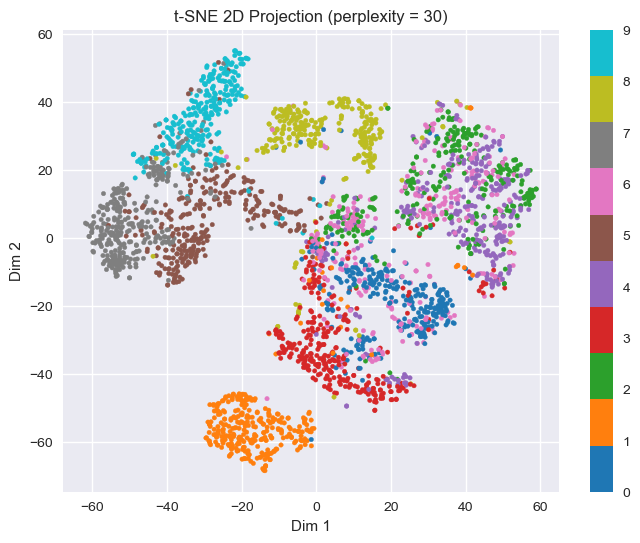

In [7]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap="tab10", s=10)
plt.title("t-SNE 2D Projection (perplexity = 30)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(scatter, ticks=range(10))
plt.show()


### t-SNE Interpretation

Compared to PCA:

- Clusters are more compact.
- Classes separate more clearly.
- Local structure is preserved.
- The layout reflects *neighbourhood relationships*, not global geometry.

This makes t-SNE ideal for understanding complex datasets like Fashion-MNIST.


## **6. Sensitivity to Perplexity**

Perplexity represents the effective number of neighbours each point considers.
Low values emphasise very local structure.
High values smooth out clusters.

We test perplexity values: 5, 30, 50.


In [8]:
perplexities = [5, 30, 50]
tsne_results = {}

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, random_state=42)
    tsne_results[p] = tsne.fit_transform(X_scaled)


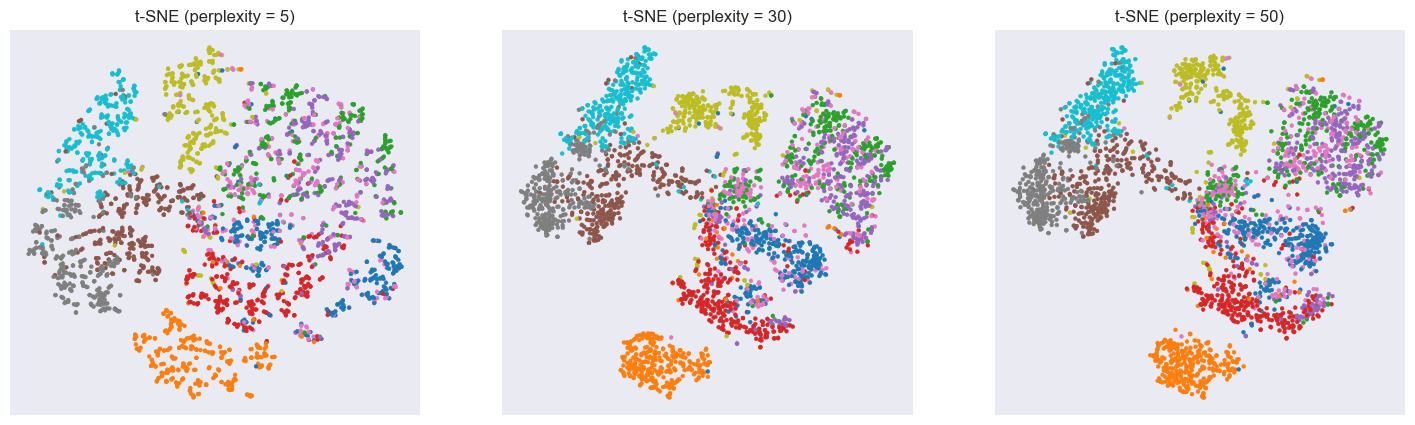

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, p in zip(axes, perplexities):
    ax.scatter(tsne_results[p][:,0], tsne_results[p][:,1], c=y, cmap="tab10", s=8)
    ax.set_title(f"t-SNE (perplexity = {p})")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## **7. Conclusion**

This tutorial demonstrated how PCA and t-SNE provide two different perspectives on the same dataset.

**PCA**
- Fast and interpretable  
- Preserves global structure  
- Fails to separate complex manifolds  

**t-SNE**
- Captures local neighbourhoods  
- Separates natural visual classes  
- Requires careful tuning of perplexity  

For Fashion-MNIST, t-SNE clearly outperforms PCA in terms of cluster visibility and meaningful separation of clothing categories.
